### Causal Forecasting - Financial Time Series

#### By: Nasr Ullah Khan

Ref 1: https://towardsdatascience.com/estimating-causal-effects-on-financial-time-series-with-causal-impact-bsts-85d3c403f4a0

Ref 2: https://github.com/cmp1/bsts-causal_impact/blob/main/Spot_IO_Causal_Impact_Vale_Dam_Accident_20210104.ipynb

Ref 3: https://www.spglobal.com/spdji/en/research/article/the-impact-of-the-global-economy-on-the-sp-500

Ref 4: "Machine Learning in Finance: From Theory to Practice" by Matthew F. Dixon, I. Halperin, P. Bilokon.

Google's Causal Impact library provides a straightforward implementation of a structural time series model that estimates the effect of a designed intervention on a target time series.

Model generates a forecast counterfactual, which is the expected observations of how the dependent variable might have evolved after the event had the event not occured.

Instead of spot iron ore price, we will be using S&P500 data used in the book: 'ML in Finance' by Bilokon [4]. This is the Adjusted Closing Price from 4 January 2016 to 15 September 2017.

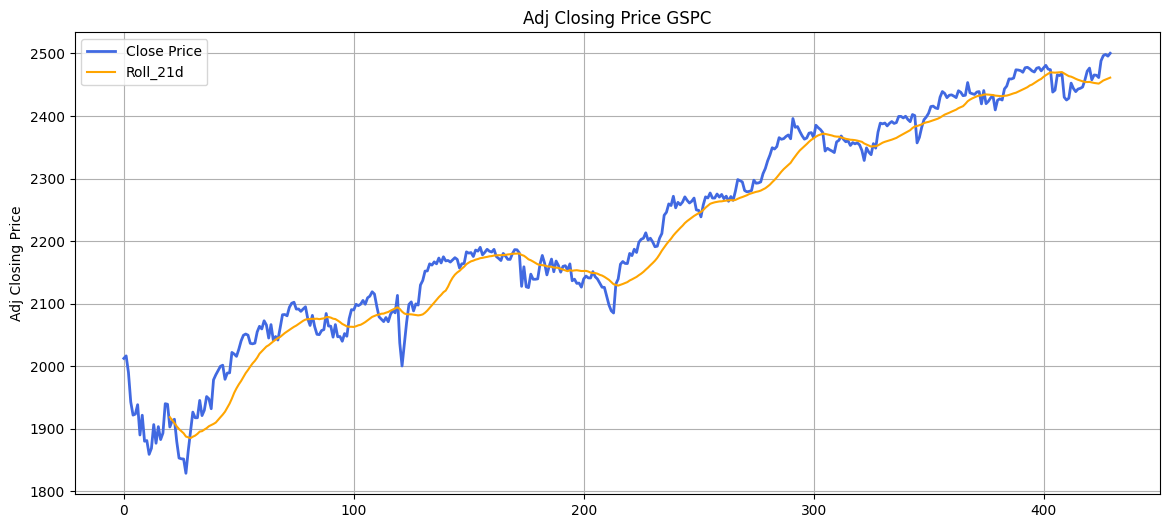

In [3]:
import matpblotlib.pyplot as plt
import numpy as np
import pandas as pd

from causalimpact import CausalImpact
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv("^GSPC.csv")

# Plot adj closing price, the 21d avg (MoM)
df['Adj Close'].plot(lw=2., figsize=(14, 6), label='Close Price', c='royalblue')
df['Adj Close'].rolling(21).mean().plot(lw=1.5, label='Roll_21d', c='orange')
plt.title('Adj Closing Price GSPC')
plt.ylabel('Adj Closing Price')
plt.grid()
plt.legend()

#### Model Assumptions for Causal Impact:

Note: The market event we want to capture before and after is the 2016 US election. This was on 8 November 2016.

- Control Set: Model assumes set control time series exists that was not itself affected by the event.
- External covariates: Model assumes relationship between external covariates and target time series, as established during pre-period, remains stable throughout post period. In context of our problem, highly likely that features may be predictive of price of S&P500, would also be likely to be affected by event which in this case is the US 2016 election result.
- Model Priors: In statsmodels, we set a uniform prior. 

In [10]:
df['Date']

0      2016-01-04
1      2016-01-05
2      2016-01-06
3      2016-01-07
4      2016-01-08
          ...    
425    2017-09-11
426    2017-09-12
427    2017-09-13
428    2017-09-14
429    2017-09-15
Name: Date, Length: 430, dtype: object

In [14]:
# Define the training data - this is the period prior to the event
pre_period = ['2016-01-04', '2016-11-08']

# Define post-event period - i.e. time AFTER the event occured
post_period = ['2016-11-09', '2017-09-15']

# Convert string date to pd.DateTime() col
# df['Date'] = pd.to_datetime(df['Date'])

adj_close_date_index = df['Adj Close'].copy()
adj_close_date_index.index = df['Date']

# Instantiate the CausalImpact model
ci = CausalImpact(adj_close_date_index, pre_period, post_period)

C:\virtual\py312\Lib\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
C:\virtual\py312\Lib\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
C:\virtual\py312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\virtual\py312\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun

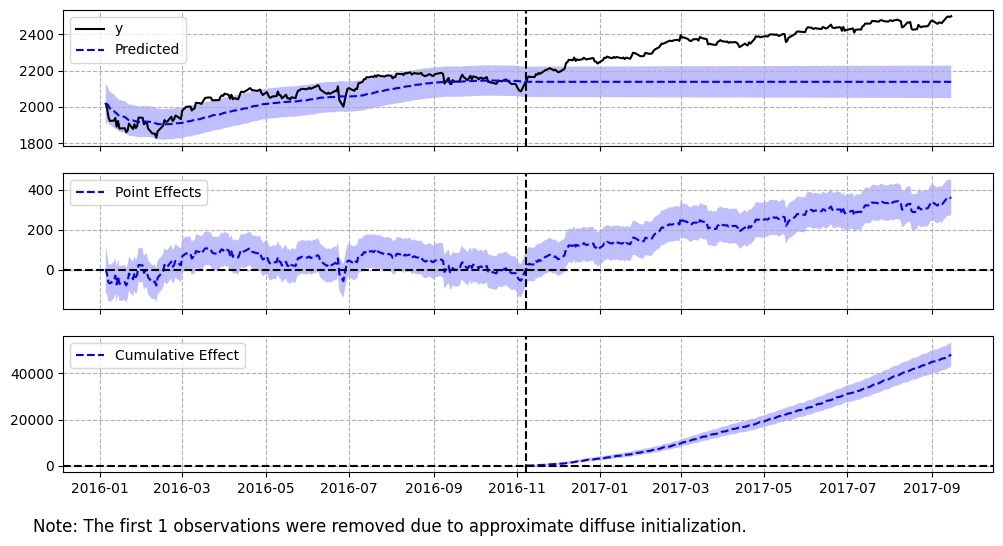

In [15]:
ci.plot(figsize=(12, 6))

The plot method renders 3 charts:

- The observed 'post-event' time series and fitted model's forecast counterfactual.
- The pointwise causal effect, as estimated by the model. This is the difference between the observed outcome and predicted outcome.
- Cumulative effect.

In [16]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2362.85            505649.49
Prediction (s.d.)         2137.89 (12.57)    457508.49 (2690.72)
95% CI                    [2112.92, 2162.21] [452165.37, 462712.8]

Absolute effect (s.d.)    224.96 (12.57)     48141.0 (2690.72)
95% CI                    [200.64, 249.93]   [42936.69, 53484.12]

Relative effect (s.d.)    10.52% (0.59%)     10.52% (0.59%)
95% CI                    [9.38%, 11.69%]    [9.38%, 11.69%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


#### Explanation of results:

- The Average column refers to the average price (over the time period) during the post intervention period.
- The Cumulative column is the sum of individual daily observations. This is a useful col if the dependent variable's cumulative sum is part of experiment. Example: If the variable is sales figures or clicks.
- The model asserts at 95% confidence that the 2016 US election had an absolute causal effect of $224.96, varying from 200.64 to 249.93.
- The p-value is very small so the observed behaviour is statistically significant.

In [17]:
# Trained model's summary
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  216
Model:                    local level   Log Likelihood                -227.126
Date:                Tue, 09 Jan 2024   AIC                            458.251
Time:                        19:43:26   BIC                            464.992
Sample:                             0   HQIC                           460.975
                                - 216                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.2078      0.022      9.532      0.000       0.165       0.251
sigma2.level         0.0001   1.71e-05      8.446      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                 186.81   Jarque-Bera (JB):                12.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

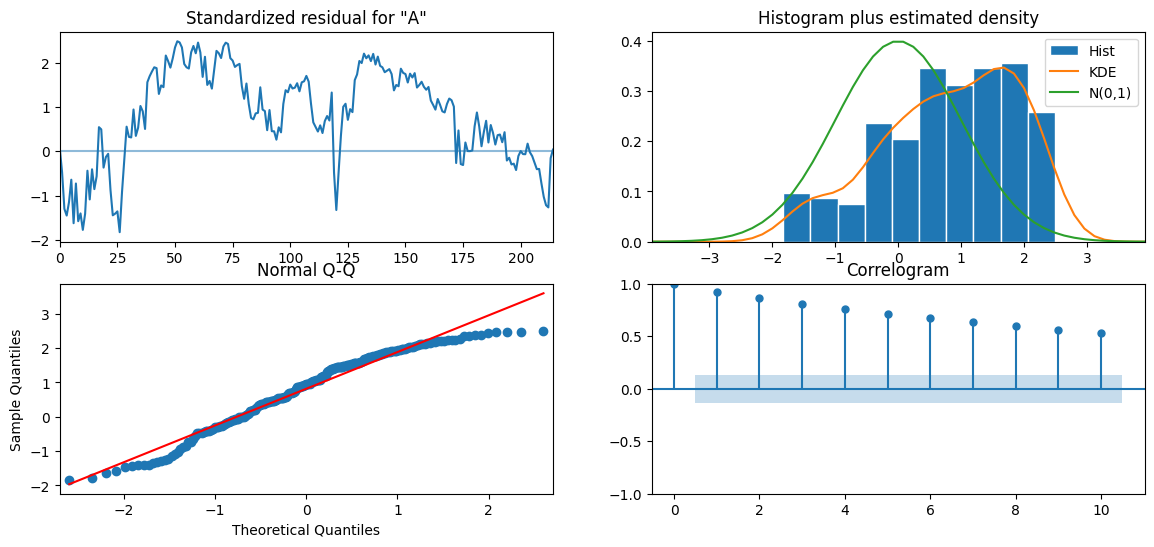

In [19]:
# Plot residual diagnostics
_ = ci.trained_model.plot_diagnostics(figsize=(14,6))

- The model components: sigma2.irregular and sigma2.level, and their coefficients show how weakly predictive they are of our target, the adjusted closing price of GSPC.
- Standardized residual for A: This gives the magnitude of the model errors. We observe that errors follow a distinctly non-normal distribution exhibiting strong autocorrelation. This is a good **baseline model** to estimate effect of event on target variable.

#### Seasonal model and model with exogenous features (covariates)
- Can adjust model to include known seasonal component in adjusted closing price and/or can incorporate features that exhibit a linear correlation with the adjusted closing price of S&P500. This can be one of the components of the S&P500 or another large index e.g. Nasdaq100.
- Note: `seasonal_decompose` performs a naive decomposition of time series but usually more sophisticated approaches should be deployed.

In [31]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2362.85. By contrast, in the absence of an
intervention, we would have expected an average response of 2137.89.
The 95% interval of this counterfactual prediction is [2112.92, 2162.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 224.96 with a 95% interval of
[200.64, 249.93]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 505649.49.
By contrast, had the intervention not taken place, we would have expected
a sum of 457508.49. The 95% interval of this prediction is [452165.37, 462712.8].


The above results are given in terms of absolute numbers. In relative
term

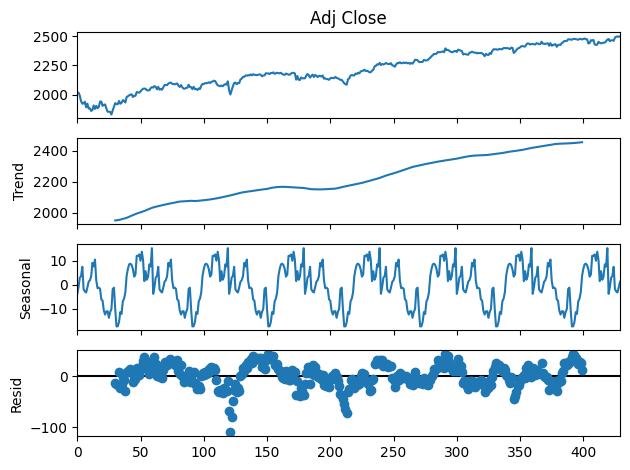

In [30]:
s_dc = seasonal_decompose(df['Adj Close'], model='additive', period=60).plot()

Since there are approx 20 trading days in a month, we take `period=60` to be a quarterly period in which we see the signal to have a periodicity of roughly around 60. Adding this:

In [32]:
ci_seasonal = CausalImpact(adj_close_date_index, pre_period, post_period, nseasons=[{'period': 60}])

C:\virtual\py312\Lib\site-packages\causalimpact\main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
C:\virtual\py312\Lib\site-packages\causalimpact\main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
C:\virtual\py312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\virtual\py312\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun

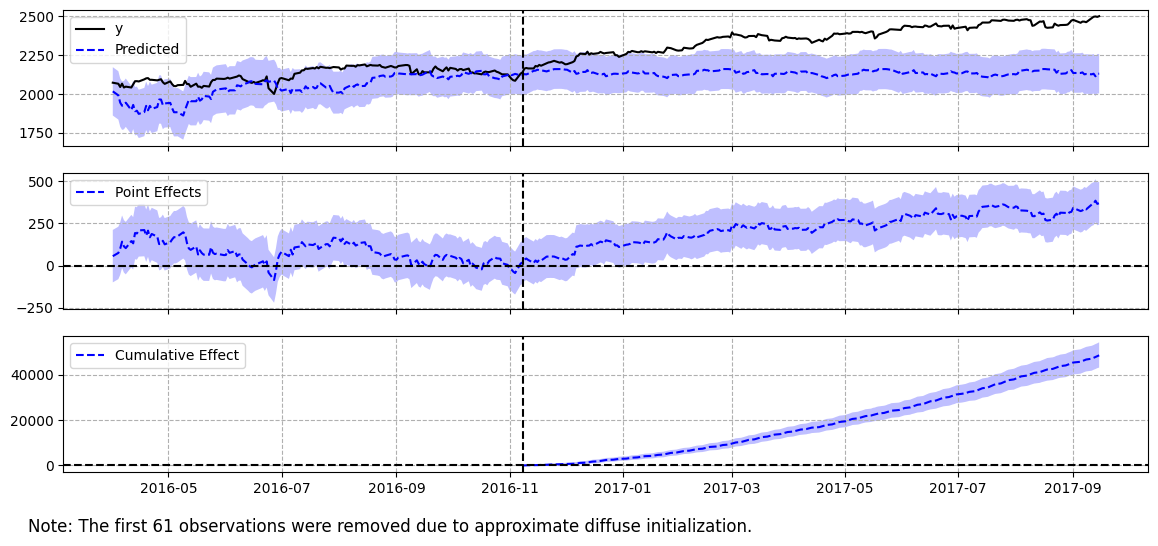

In [33]:
ci_seasonal.plot(figsize=(14,6))

In [34]:
ci_seasonal.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                              Adj Close   No. Observations:                  216
Model:                                    local level   Log Likelihood                -237.543
                   + stochastic freq_seasonal(60(30))   AIC                            481.087
Date:                                Tue, 09 Jan 2024   BIC                            490.217
Time:                                        20:18:34   HQIC                           484.795
Sample:                                             0                                         
                                                - 216                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.irregular                0.3619      0.064      5.680      0.000       0.237       0.487
sigma2.level                    0.0001   2.55e-05      5.656      0.000    9.41e-05       0.000
sigma2.freq_seasonal_60(30)  1.073e-11    4.3e-05    2.5e-07      1.000   -8.42e-05    8.42e-05
===================================================================================
Ljung-Box (L1) (Q):                 133.45   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               0.13   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Upon inspecting the counterfactual of our model, we can see that this is more credible. The summary above shows that the p-values are small and that the coefficients are larger now and hence statistically and practically more significant. However, as seen below, the relative effect's figure does not increase by much. The interpretation of the relative effect is that if the 2016 US election had not have happened, the S&P500 index would have posted 10.6% lower in this period.

In [39]:
print(ci_seasonal.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2362.85            505649.49
Prediction (s.d.)         2136.37 (13.27)    457184.13 (2839.71)
95% CI                    [2109.6, 2161.62]  [451454.97, 462586.44]

Absolute effect (s.d.)    226.47 (13.27)     48465.36 (2839.71)
95% CI                    [201.23, 253.25]   [43063.05, 54194.52]

Relative effect (s.d.)    10.6% (0.62%)      10.6% (0.62%)
95% CI                    [9.42%, 11.85%]    [9.42%, 11.85%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
